# Action Log Analysis



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
"""Read action log into a pandas dataframe"""

def dateparse (timestamp):    
    return datetime.datetime.fromtimestamp(float(timestamp))

log = pd.read_csv("./Data/higgs-activity_time.txt", delimiter=" ",
                  index_col="time", parse_dates=True, date_parser=dateparse)

print(log.shape[0])

users = log["user2"].drop_duplicates()
print(log.head())

563069
                      user1   user2 type
time                                    
2012-06-30 17:02:52  223789  213163   MT
2012-06-30 17:02:52  223789  213163   RE
2012-06-30 17:06:21  376989   50329   RT
2012-06-30 17:06:23   26375  168366   MT
2012-06-30 17:06:32  376989   13813   RT


In [3]:
fr=350423.
u=212646.
tot=563069.

print(fr/tot)
print(u/tot)
print((fr + u)/tot)

0.6223446859976308
0.3776553140023692
1.0


In [36]:
log = pd.read_csv("./Data/higgs-activity_time.txt", delimiter=" ", index_col="time")
period_1_from, period_1_to = 0, 1341187199 # 1st July 23:59:59 GMT
period_2_from = period_1_to + 1
period_2_to = 1341233999                   # 2nd July 12:59:59 GMT
period_3_from = period_2_to + 1
period_3_to = 1341388799                   # 3rd July 23:59:59 GMT
period_4_from = period_3_to + 1
period_4_to = 9999999999                   # Heat death

p1 = log.truncate(before=period_1_from, after=period_1_to).shape[0]
p2 = log.truncate(before=period_2_from, after=period_2_to).shape[0]
p3 = log.truncate(before=period_3_from, after=period_3_to).shape[0]
p4 = log.truncate(before=period_4_from, after=period_4_to).shape[0]


print(p1, p2, p3, p4)

4170 3720 171196 383983


In [25]:
"""Split a dataset into n unequal time intervals"""

def split_dataset(df, n, tmin, timedeltas):
    """df must have date index, and timedeltas must stay in range"""
    
    splits = []
    
    _min = tmin
    _max = tmin + timedeltas[0]
    
    for i in range(1,n):
        split = df.truncate(before=_min, after=_max)
        splits.append(split)
        _min = _max
        _max = _max + timedeltas[i]
    
    split = df.truncate(before=_min, after=_max)
    splits.append(split)
        
    return splits

# Split dataset into periods I, II, III, IV 
num_periods = 4
tmin = log.index.min()
tmax = log.index.max()

t1 = 1.0
t2 = 2.0
t3 = 1.0
t4 = 3.7

s1 = t1
s2 = s1 + t2
s3 = s2 + t3
s4 = s3 + t4

timedeltas = [datetime.timedelta(days=t1),
                datetime.timedelta(days=t2),
                datetime.timedelta(days=t3),
                datetime.timedelta(days=t4)]
splits = split_dataset(log, num_periods, tmin, timedeltas)

for i in range(num_periods):
    print("Split {} has {} actions".format(i, splits[i].shape[0]))
    print(splits[i].index.min(), splits[i].index.max())

print(log.tail())

TypeError: unsupported operand type(s) for +: 'int' and 'datetime.timedelta'

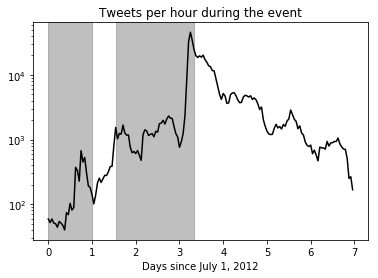

In [58]:
"""Make plot of tweets/hour"""

import matplotlib.dates as mdates

tmin = log.index.min()
tmax = log.index.max()

dt = 3600 #datetime.timedelta(hours=1.0)
T = []
t = tmin
tweets_per_hour = []
while t < tmax:
    tweets_per_hour.append(log.truncate(before=t, after=t+dt).shape[0])
    T.append(t)
    t += dt
T = T - T[0]

(fig, ax) = plt.subplots()
ax.semilogy(T, tweets_per_hour, color="k")
ax.axvspan(0, period_1_to-tmin, alpha=0.5, color='grey')
ax.axvspan(period_3_from-tmin, period_3_to-tmin, alpha=0.5, color='grey')
plt.title("Tweets per hour during the event")
plt.xlabel("Days since July 1, 2012")
plt.xticks(np.arange(8)*3600*24, np.arange(8))
plt.savefig("Report/Figures/tweetsperhour.png")
plt.show()

## Table 1: activities / period
| Period | #activities |
| ------------- |:-------------:|
| I      | 4181        |
| II     | 49604       |
| III    | 356539      |
| IV     | 152747      |


2012-06-30 17:02:52 2012-07-01 17:02:33

2012-07-01 17:03:37 2012-07-03 17:02:47

2012-07-03 17:02:54 2012-07-04 17:02:52


In [13]:
# Count occurences of users as (mentioned, retweeted, replied)

#print(log.shape[0])

users = log["user2"].drop_duplicates()
#print(users.shape[0])

counts = np.zeros((users.shape[0], num_periods), dtype=np.uint32)
user_index = np.zeros(users.shape[0], dtype=np.uint32)

first = True
for i in range(num_periods):
    print(i)
    split = splits[i]
    j = 0
    for user in users:
        if first:
            user_index[j] = user
        counts[j][i] = (split[split["user2"] == user]).shape[0]
        j += 1
    first = not first
        

0
1
2
3


In [14]:
print(counts[0:10, :])
print(user_index[0:10])

[[   3    0    3    0]
 [   5   26    4   15]
 [   1    0    0    0]
 [   5   88 1750   68]
 [  23  594  642   21]
 [   2    2    0    0]
 [   1    0    0    0]
 [   1    0    5    7]
 [  15   11    7    7]
 [   2   24  349   33]]
[213163  50329 168366  13813      8 364376 364375  60337  84647  42182]


## Cluster users

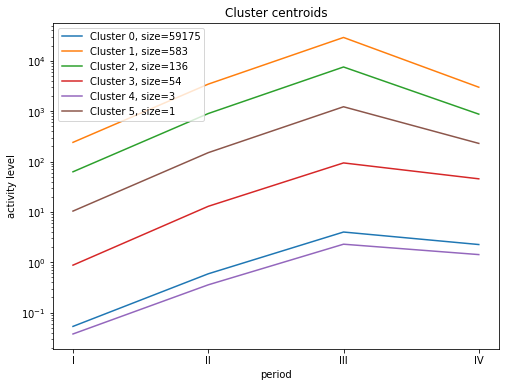

In [90]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data = counts
num_clusters = 4

# Cluster once
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)

kmeans.fit(reduced_data)

centroids = kmeans.cluster_centers_
i_centroids = pca.inverse_transform(centroids)

clusters = []
for i in range(num_clusters):
    (c,) = np.where(kmeans.labels_ == i)
    clusters.append(c)

# Have now clustered once, do it again on clusters[0]
cl0_reduced_data = reduced_data[clusters[0]]
del clusters[0]

kmeans.fit(cl0_reduced_data)
cl0_centroids = kmeans.cluster_centers_
cl0_i_centroids = pca.inverse_transform(cl0_centroids)

num_clusters = 3
cl0_clusters = []
for i in range(num_clusters):
    (c,) = np.where(kmeans.labels_ == i)
    cl0_clusters.append(c)

clusters = clusters + cl0_clusters
cluster_sizes = [len(c) for c in clusters]

i_centroids = np.concatenate((i_centroids, cl0_i_centroids))
sorted_ind = np.argsort(cluster_sizes)
cluster_sizes = sorted(cluster_sizes, reverse=True)
i_centroids = i_centroids[sorted_ind,:]

    
# Plot centroids along time-axis
fig = plt.figure(figsize=(8, 6))
handles = []
P = range(num_periods)

for i in range(len(clusters)):
    h, = plt.semilogy(P, i_centroids[i,:], label="Cluster {}, size={}".format(i, cluster_sizes[i]))
    handles.append(h)

plt.legend(handles=handles)
plt.xticks(P, ["I", "II", "III", "IV"])
plt.title("Cluster centroids")
plt.xlabel("period")
plt.ylabel("activity level")
#plt.savefig("Report/Figures/centroids.png")
plt.show()

In [ ]:
"""Find a unique (cluster 1) user"""

averages = [0]*num_clusters

for i in range(1,num_clusters):

    users_in_cluster = user_index[np.where(kmeans.labels_ == i)]
    avg = 0.0
    for user in users_in_cluster:
        avg += (log[log["user2"] == user]).shape[0]
    avg /= len(users_in_cluster)
    averages[i] = avg
    
print(averages)